In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !ls "/content/drive/My Drive"

In [3]:
# %cd /content/drive/My Drive/AI&ML/CV/CV_project_2

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
import os
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
import cv2
# from google.colab.patches import cv2_imshow

import time

In [5]:
# Initialize the random number generator
import random
random.seed(10)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
tf.__version__

'2.9.1'

# **Part A**

## **1. Import and Understand the data**

In [6]:
# Import and read ‘images.npy’
data = np.load('images.npy', allow_pickle=True)

In [7]:
data.shape

(409, 2)

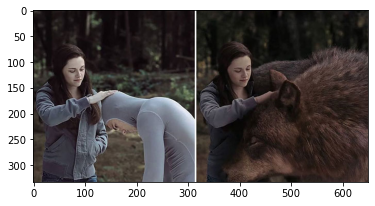

In [8]:
# Check the images
plt.imshow(data[0][0])

In [9]:
print(data[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


## **B. Split the data into Features(X) & labels(Y). Unify shape of all the images.**

In [10]:
# Split the data into Features(X) & labels(Y). Unify shape of all the images.
img_height = 224
img_width = 224

y = np.zeros((data.shape[0], img_height, img_width))
X = np.zeros((data.shape[0],img_height, img_width, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:,:,:3]    
    except:
        print(f"Exception for Grayscale image at index {index} with shape {img.shape}")
        # convert the grayscale image to color so that the number of channels are standardized to 3
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    # Loop through the face co-ordinates and create mask out of it.
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * img_width)
        x2 = int(i['points'][1]['x'] * img_width)
        y1 = int(i['points'][0]['y'] * img_height)
        y2 = int(i['points'][1]['y'] * img_height)
        
        # set all pixels within the mask co-ordinates to 1.
        y[index][y1:y2, x1:x2] = 1

Exception for Grayscale image at index 272 with shape (224, 224)


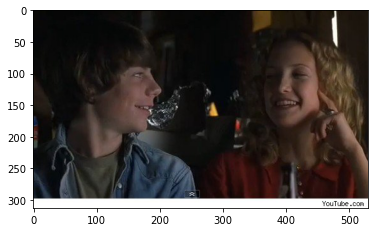

In [11]:
# Check for the image and mask generated corresponding to it
plt.imshow(data[200][0])

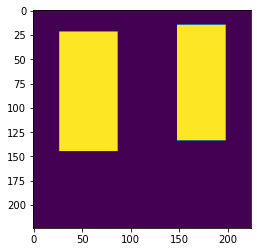

In [12]:
plt.imshow(y[200])

## **C. Split the data into train and test[400:9]**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=9, shuffle=True)

In [14]:
X_train.shape

(400, 224, 224, 3)

In [15]:
X_test.shape

(9, 224, 224, 3)

## **D. Select random image from the train data and display original image and masked image.**

In [16]:
# display image(s)
def display_images(imgs, rows, cols):
    plt.figure(figsize = (15, 15))
    i = 0
    while len(imgs) > i:
        plt.subplot(rows,cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = imgs[i]
        plt.imshow(img)
        i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


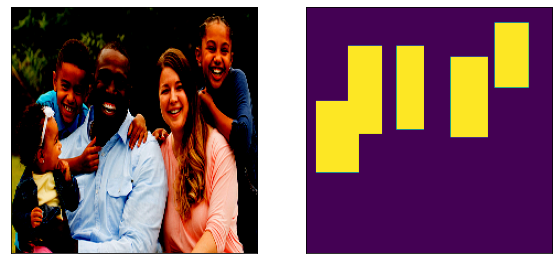

In [17]:
# displaying random image along with its masked image
random = randint(0,400)
display_images([X_train[random], y_train[random]], 1,3)

# **2. Model building**

### **A. Design a face mask detection model.**

In [18]:
height_cells = 28
width_cells = 28
batch_size = 8

# ----
lr=1e-4
beta_1=0.9
beta_2=0.999

In [19]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, alpha=1, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block1 = model.layers[0].input
    block2 = model.get_layer("conv_pw_1_relu").output
    block3 = model.get_layer("conv_pw_2_relu").output
    block4 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_5_relu").output
    block6 = model.get_layer("conv_pw_11_relu").output
    block7 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block7), block6])
    x = Concatenate()([UpSampling2D()(x), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    plt.xlabel = Reshape((img_height, img_width))(x)

    return Model(inputs=model.input, outputs=x)

In [20]:
model = create_model()

# Print summary
model.summary()

2022-11-18 21:06:14.926865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

### **B. Design your own Dice Coefficient and Loss function.**

In [21]:
# the dice coefficient
def dice_coef(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [22]:
# the loss function
def dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coef(y_true, y_pred) + tf.keras.backend.epsilon())

In [23]:
%%time

metrics = [dice_coef, Recall(), Precision()]
optimizer = tf.keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=0.01, decay=0.0, amsgrad=False)
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

CPU times: user 12.5 ms, sys: 1.89 ms, total: 14.4 ms
Wall time: 12.7 ms


In [24]:
callbacks = [
    ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

### **C. Train and tune the model as required**

In [25]:
%%time

# Train and tune the model
EPOCHS=30
train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 1.6444 - dice_coef: 0.3221 - recall: 0.4294 - precision: 0.3245
Epoch 1: val_loss improved from inf to 1.56765, saving model to model-1.57.h5
50/50 [==============================] - 377s 7s/step - loss: 1.6444 - dice_coef: 0.3221 - recall: 0.4294 - precision: 0.3245 - val_loss: 1.5676 - val_dice_coef: 0.2933 - val_recall: 0.1959 - val_precision: 0.4550 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 1.1146 - dice_coef: 0.4724 - recall: 0.5414 - precision: 0.5004
Epoch 2: val_loss improved from 1.56765 to 1.52842, saving model to model-1.53.h5
50/50 [==============================] - 283s 5s/step - loss: 1.1146 - dice_coef: 0.4724 - recall: 0.5414 - precision: 0.5004 - val_loss: 1.5284 - val_dice_coef: 0.3077 - val_recall: 0.2175 - val_precision: 0.5752 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.9962 - dice_coef: 0.5119 - recall: 0.5608 - 

Epoch 20/30
50/50 [==============================] - ETA: 0s - loss: 0.4843 - dice_coef: 0.7218 - recall: 0.7505 - precision: 0.7904
Epoch 20: val_loss did not improve from 0.90392
50/50 [==============================] - 299s 6s/step - loss: 0.4843 - dice_coef: 0.7218 - recall: 0.7505 - precision: 0.7904 - val_loss: 0.9235 - val_dice_coef: 0.5177 - val_recall: 0.5025 - val_precision: 0.6535 - lr: 1.0000e-04
Epoch 21/30
50/50 [==============================] - ETA: 0s - loss: 0.4716 - dice_coef: 0.7272 - recall: 0.7611 - precision: 0.7923
Epoch 21: val_loss did not improve from 0.90392
50/50 [==============================] - 287s 6s/step - loss: 0.4716 - dice_coef: 0.7272 - recall: 0.7611 - precision: 0.7923 - val_loss: 0.9100 - val_dice_coef: 0.5225 - val_recall: 0.5063 - val_precision: 0.6591 - lr: 1.0000e-04
Epoch 22/30
50/50 [==============================] - ETA: 0s - loss: 0.4560 - dice_coef: 0.7356 - recall: 0.7728 - precision: 0.7951
Epoch 22: val_loss did not improve from 0.9

## **D. Evaluate and share insights on performance of the model.**

In [26]:
# Evaluate the model
test_steps = (len(X_test)//batch_size)
if len(X_test) % batch_size != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

2/2 [==============================] - 2s 1s/step - loss: 0.8792 - dice_coef: 0.5362 - recall: 0.5356 - precision: 0.6626


[0.8791747093200684,
 0.5362368822097778,
 0.5355646014213562,
 0.6625881195068359]

**Insights on performance from the evaluation of model:**

The model has precision and recall of 66.26% and 53.56% respectively. The loss is 87.92% and dice coefficient is 66.26% on the test data, which seems to be a ok score.

## **3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.**

In [27]:
test_image = X_test[3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


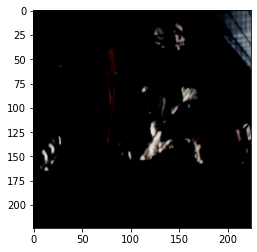

In [28]:
plt.imshow(test_image)

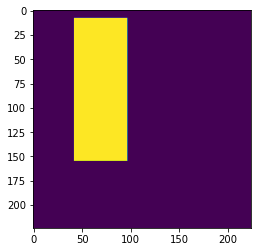

In [29]:
plt.imshow(y_test[3])

In [30]:
y_pred = model.predict(np.array([test_image]))


1/1 [==============================] - 1s 925ms/step


In [31]:
print(y_test[3].shape)
print(y_pred.shape)
y_pred

(224, 224)
(1, 224, 224, 1)


array([[[[5.6922358e-06],
         [5.6947392e-06],
         [5.9298809e-06],
         ...,
         [1.8686042e-07],
         [2.8315924e-07],
         [2.8526256e-07]],

        [[5.6873796e-06],
         [5.6898803e-06],
         [5.9197610e-06],
         ...,
         [1.8752880e-07],
         [2.8301130e-07],
         [2.8451973e-07]],

        [[4.2881638e-06],
         [4.2874972e-06],
         [8.9177192e-06],
         ...,
         [2.3789703e-07],
         [1.9984013e-07],
         [2.0022931e-07]],

        ...,

        [[1.2018906e-05],
         [1.2015033e-05],
         [2.1378362e-05],
         ...,
         [7.0656315e-05],
         [5.5731169e-05],
         [5.5725119e-05]],

        [[1.4528494e-05],
         [1.4527288e-05],
         [1.7830645e-05],
         ...,
         [5.1031057e-05],
         [8.8935114e-05],
         [8.8997294e-05]],

        [[1.4528494e-05],
         [1.4535562e-05],
         [1.7830645e-05],
         ...,
         [5.1089191e-05],
        

In [32]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (224,224))

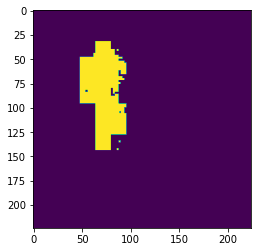

In [33]:
plt.imshow(pred_mask, alpha=1)